## Data prepararion - PDF pre-processing

The Data Preparation phase of the IBM's CRISP model is about preparing the final dataset to be used in the later stages. In this phase, the table, record, and attribute selection, as well as transformation and cleaning are considered. Practice shows that these tasks are likely to be performed multiple times.

This notebook focuses on the extraction of the 5 statement categories (mission, visions, core values, strategies, goals) from PDF files. At the end, a csv/json files are produced which is the data we will feed the model to determine the final candidates for the 5 above-mentioned pillars.

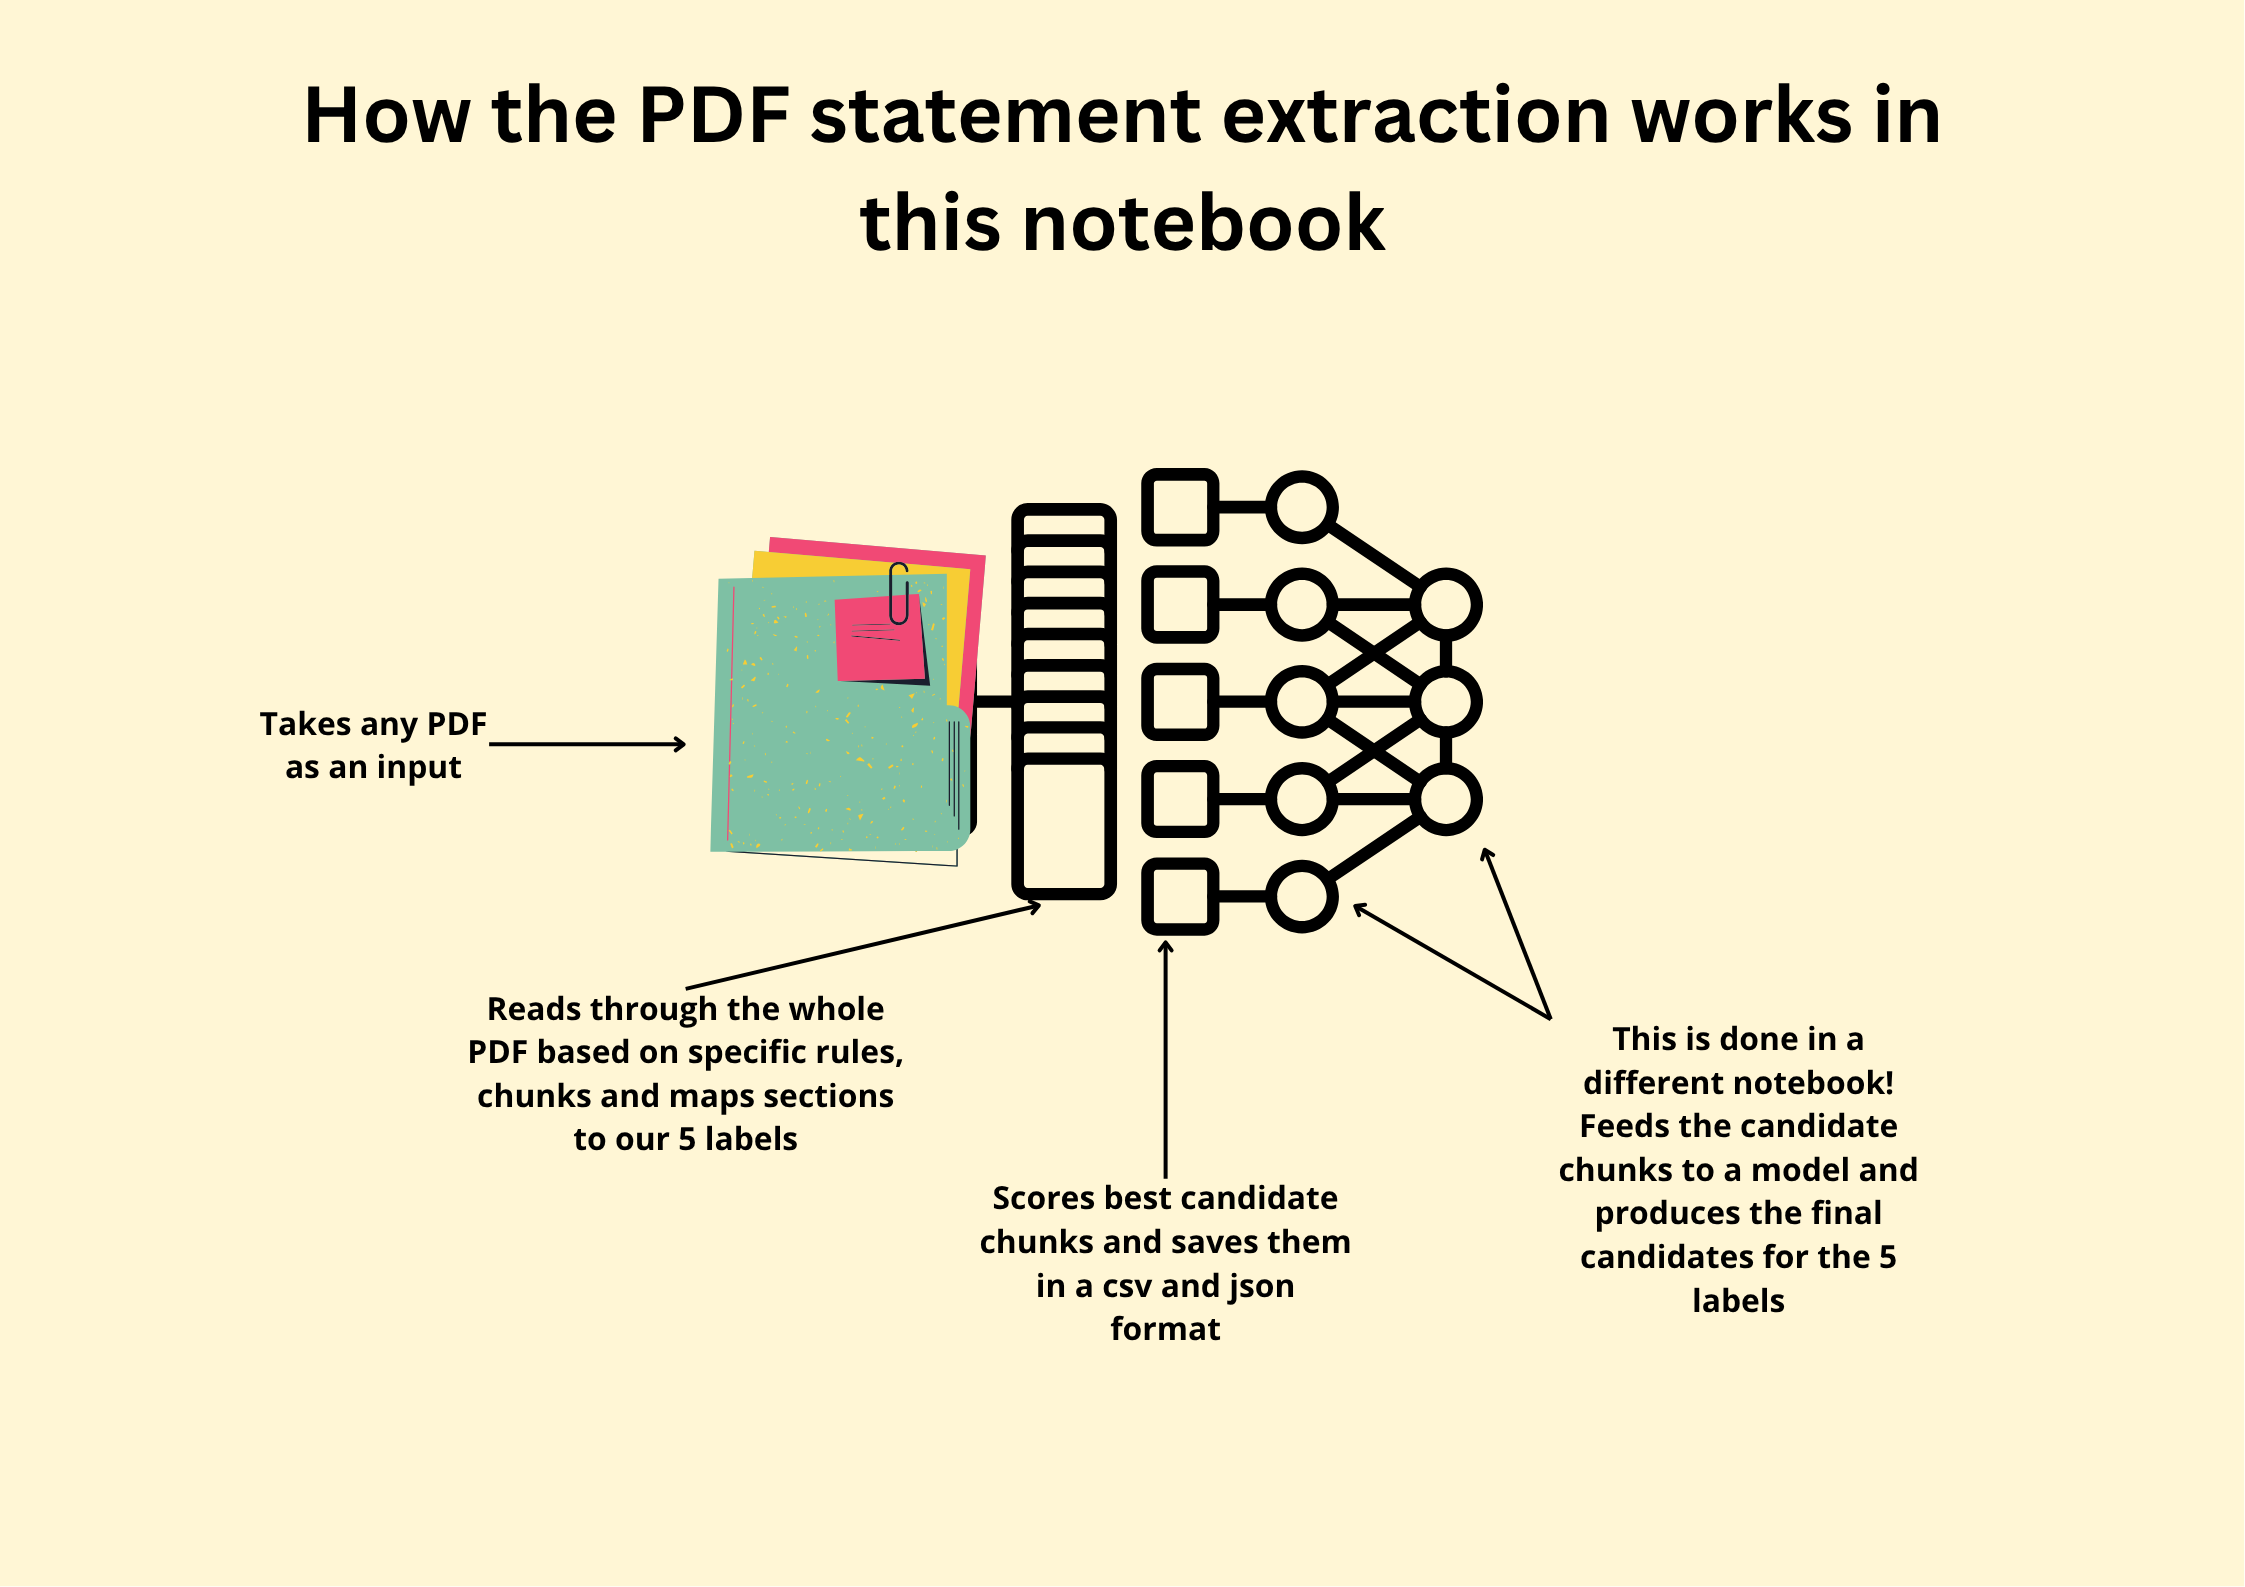


## 1) Setup
Handels the necessary installation of packages.

In [1]:

%pip install -q "pymupdf==1.24.10" "pandas==2.2.2" "tqdm==4.66.5"
import re, io, json, sys, platform
from pathlib import Path
import pandas as pd, fitz
import unicodedata
print("Python", sys.version.split()[0], "| OS:", platform.platform())
print("PyMuPDF", fitz.__doc__.splitlines()[0] if fitz.__doc__ else "OK")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 85.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.
Python 3.12.12 | OS: Linux-6.6.105+-x86_64-with-glibc2.35
PyMuPDF PyMuPDF 1.24.10: Python bindings for the MuPDF 1.24.9 library (rebased implementation).


## 2) Configuration

### This part of the notebook defines how the system recognizes which topic a paragraph belongs to, when there is no clear section heading in the PDF.

*   With "LABELS" we define the five organizational elements we want to detect in an annual report.


*   With "GENERIC_HINTS" define keywords that are commonly associated with each label



In [2]:

LABELS = ["Mission","Vision","Goals","Core Values","Strategy"]

# Generic hints (fallback)
GENERIC_HINTS = {
    # English
    "Mission": [r"\bmission\b", r"\bpurpose\b", r"\bour purpose\b", r"\bwhy we exist\b"],
    "Vision":  [r"\bvision\b",  r"\bour vision\b", r"\bambition\b", r"\baspiration\b"],
    "Goals":   [r"\bgoals?\b",  r"\btargets?\b", r"\bobjectives?\b", r"\bKPIs?\b"],
    "Core Values": [r"\bvalues?\b", r"\bguiding principles?\b", r"\bwhat we stand for\b"],
    "Strategy": [r"\bstrategy\b", r"\bstrategic\b", r"\bbusiness model\b", r"\bvalue creation\b", r"\bpillars?\b"],
    # Dutch
    "Mission": [r"\bmissie\b", r"\bdoel\b", r"\bonze missie\b"],
    "Vision":  [r"\bvisie\b", r"\bonze visie\b", r"\bambitie\b"],
    "Goals":   [r"\bdoelen?\b", r"\bdoelstelling(en)?\b", r"\bKPI'?s?\b", r"\btargets?\b"],
    "Core Values": [r"\bkernwaarden\b", r"\bwaarden\b", r"\bleidende principes?\b", r"\bwaar wij voor staan\b"],
    "Strategy": [r"\bstrategie\b", r"\bstrategisch(e)?\b", r"\bbedrijfsmodel\b", r"\bwaardecreatie\b", r"\b(pijlers|pilaren)\b"]
}
GENERIC_PAT = {k:[re.compile(p, re.I) for p in v] for k,v in GENERIC_HINTS.items()}


## 3) Parsing utilities

###This function reads each PDF page, falls back to OCR if there’s no text layer, reconstructs two-column reading order using x-positions, keeps font sizes for header detection, cleans minor noise, and returns both full page text and line-by-line data for the later extraction steps.

In [3]:

from PIL import Image
try:
    import pytesseract
    OCR_AVAILABLE = True
except Exception:
    OCR_AVAILABLE = False

def strip_noise(text: str) -> str:
    text = re.sub(r"^\s*\d{1,3}\s*$", "", text, flags=re.M)
    text = re.sub(r"(©|copyright).*$", "", text, flags=re.I|re.M)
    return text

def ocr_page(page, dpi=200):
    if not OCR_AVAILABLE:
        return ""
    try:
        pix = page.get_pixmap(dpi=dpi)
        img = Image.open(io.BytesIO(pix.tobytes(output="png")))
        return pytesseract.image_to_string(img)
    except Exception:
        return ""

def page_text_with_lines(doc):
    pages=[]
    for pno in range(len(doc)):
        page = doc[pno]
        text_try = page.get_text()
        if not (text_try or "").strip():
            text_try = ocr_page(page)

        raw = page.get_text("dict") if (text_try or "").strip() else {"blocks":[]}
        columns, col_xs = {}, []
        for b in raw["blocks"]:
            if "lines" not in b:
                continue
            bx0, _, _, _ = b.get("bbox", (0,0,0,0))
            assigned = None
            for i, cx in enumerate(col_xs):
                if abs(bx0 - cx) < 40:
                    assigned = i; break
            if assigned is None:
                col_xs.append(bx0); assigned = len(col_xs)-1
            for l in b["lines"]:
                spans = l.get("spans", [])
                txt = "".join(s.get("text","") for s in spans).strip()
                if not txt:
                    continue
                max_sz = max((s.get("size", 0) for s in spans if "size" in s), default=0)
                y0 = min((s.get("bbox",[0,0,0,0])[1] for s in spans if "bbox" in s), default=0)
                columns.setdefault(assigned, []).append((y0, txt, max_sz))

        stitched=[]
        for idx in sorted(columns.keys(), key=lambda i: col_xs[i]):
            for y0, txt, sz in sorted(columns[idx], key=lambda t: t[0]):
                stitched.append((txt, sz))

        full = "\n".join(t for t,_ in stitched)
        full = strip_noise(full)
        pages.append({"page": pno, "lines": stitched, "text": full})
    return pages


## 4) Header detection + header→label mapping

### In the next cell we detect headings using font size, caps, and regex; map the heading text to one of five categories (Mission, Vision, Goals, Core Values, Strategy) using English/Dutch synonyms; then capture the following paragraphs as that section’s content, with size limits and hyphenation repair.

In [4]:

#Map header words → our five labels
HEADER_PATTERNS = [
    # English
    r"^(mission|vision|purpose|values?|core values?|strategy|strategic (priorities|pillars|framework)|objectives?|goals?|business model|value creation)\b",
    r"^(who we are|about us|our (ambition|aim|promise)|company profile)\b",
    # Dutch
    r"^(missie|visie|doelen|doel(en)?|doelstelling(en)?|kernwaarden|waarden|strategie|strategische (prioriteiten|pijlers|kaders)|bedrijfsmodel|waardecreatie)\b",
    r"^(wie wij zijn|wie we zijn|over ons|onze ambitie|ons doel|bedrijfsprofiel)\b"
]
HEADER_RE = [re.compile(p, re.I) for p in HEADER_PATTERNS]

HEADER_TO_LABEL_PATTERNS = {
    "Mission": [
        r"\bmission\b", r"\bour mission\b", r"\bwhy we exist\b", r"\bour purpose\b",
        r"\bpurpose\b", r"\bwho we are\b", r"\bwhat we do\b", r"\bcompany purpose\b", r"\bthe reason we exist\b",
        r"\bmissie\b", r"\bonze missie\b", r"\bwaarom we bestaan\b", r"\bdoel\b(?!stelling)", r"\bons doel\b", r"\bwaar wij voor bestaan\b"
    ],
    "Vision": [
        r"\bvision\b", r"\bour vision\b", r"\bshared vision\b", r"\bambition\b", r"\bour ambition\b",
        r"\baspiration\b", r"\bfuture direction\b", r"\bour future\b", r"\blong-term outlook\b",
        r"\bvisie\b", r"\bonze visie\b", r"\bambitie\b", r"\bonze ambitie\b", r"\btoekomstbeeld\b", r"\blange termijn visie\b", r"\bonze toekomst\b"
    ],
    "Goals": [
        r"\bgoals?\b", r"\bobjectives?\b", r"\btargets?\b", r"\bcommitments?\b", r"\bperformance goals?\b",
        r"\bkey (performance )?indicators?\b", r"\bKPIs?\b", r"\bwhat we aim to achieve\b",
        r"\bdoelen?\b", r"\bdoelstelling(en)?\b", r"\btargets?\b", r"\bprestatie-indicatoren\b", r"\bKPI'?s?\b", r"\bonze doelstelling(en)?\b", r"\bwat we willen bereiken\b"
    ],
    "Core Values": [
        r"\bcore values?\b", r"\bvalues?\b", r"\bcompany values?\b", r"\bwhat we stand for\b", r"\bour culture\b",
        r"\bguiding principles?\b", r"\bbeliefs?\b", r"\bethical principles?\b",
        r"\bkernwaarden\b", r"\bwaarden\b", r"\bonze waarden\b", r"\bwaar wij voor staan\b", r"\bonze cultuur\b", r"\bleidende principes?\b", r"\bovertuigingen\b"
    ],
    "Strategy": [
        r"\bstrategy\b", r"\bstrategic\b", r"\bstrategic priorities\b", r"\bstrategic pillars?\b", r"\bstrategic framework\b",
        r"\bstrategy execution\b", r"\bbusiness model\b", r"\boperating model\b", r"\bvalue creation\b", r"\bour plan\b", r"\bhow we create value\b",
        r"\bstrategie\b", r"\bstrategisch(e)?\b", r"\bstrategische prioriteiten\b", r"\bstrategische pijlers?\b", r"\bstrategisch kader\b",
        r"\bbedrijfsmodel\b", r"\boperating model\b", r"\bwaardecreatie\b", r"\bhoe wij waarde creëren\b", r"\bons plan\b"
    ]
}
HEADER_TO_LABEL_RE = {lab: [re.compile(p, re.I) for p in pats] for lab, pats in HEADER_TO_LABEL_PATTERNS.items()}

# Decides if a line is a header:
#Size hint: header font ≥ 1.25× page average → likely a title.
#Regex hint: header line matches our header patterns.
#ALL CAPS hint: short, all-caps lines often are headings.
#If any is true → treat as a header.
def is_header(line: str, size: float, avg_size: float) -> bool:
    size_hint = size >= (avg_size * 1.25)
    regex_hint = any(r.search(line.strip()) for r in HEADER_RE)
    allcaps_hint = (line.isupper() and len(line) <= 80 and len(line.split()) <= 10)
    return size_hint or regex_hint or allcaps_hint

#Converts a header line to a label - Tries the comprehensive dictionary HEADER_TO_LABEL_PATTERNS.
#If a match is found, returns one of our five target labels.
#If not, returns None (we can still keep the block but without a strong label).
def infer_label_from_header(header_text: str):
    for lab, regs in HEADER_TO_LABEL_RE.items():
        if any(r.search(header_text) for r in regs):
            return lab
    return None

#Builds the content under each header
# window_lines=60: generous look-ahead so we don’t cut the section too early.
#char_cap=2600: prevents accidental capture of huge sections.
#Hyphenation repair: merges words broken at line endings.
#Returns a list of blocks; each has the full text (header + body) and an optional hint_label (if the header matched our label dictionary).
def build_blocks_from_headers(lines, window_lines: int = 60, char_cap: int = 2600):
    if not lines:
        return []
    avg = sum(sz for _, sz in lines) / max(1, len(lines))
    headers = [i for i,(t,sz) in enumerate(lines) if is_header(t, sz, avg)]
    blocks = []
    for idx in headers:
        header_text = lines[idx][0]
        hint_label = infer_label_from_header(header_text)
        buf = [header_text]
        chars = len(header_text)
        for j in range(idx+1, min(len(lines), idx+1+window_lines)):
            t, sz = lines[j]
            if is_header(t, sz, avg):
                break
            t = re.sub(r"(\w)-\n(\w)", r"\1\2", t)
            buf.append(t)
            chars += len(t) + 1
            if chars >= char_cap:
                break
        block_text = "\n".join(buf).strip()
        block_text = re.sub(r"(\w)-\n(\w)", r"\1\2", block_text)
        block_text = re.sub(r"\n(?!\n)", " ", block_text)
        if len(block_text) >= 50:
            blocks.append({"text": block_text, "hint_label": hint_label})
    return blocks


## 5) Front matter sampling

###Not all important statements (like mission or vision) appear under clear headings. Very often, they appear in the first few pages — for example, in the CEO letter, introduction, or company overview.
###This function extracts meaningful text blocks from the beginning of the report, even when no header is present. So it acts as a safety net that allows the system to still find relevant content when the document layout does not follow standard section headings.

In [5]:

def collect_front_matter(pages, first_pages: int = 20, block_char_cap: int = 2000): ##only looks at the first 20 pages, where mvgs usually appear early
    blocks = []
    for pg in pages[:min(first_pages, len(pages))]:
        text = re.sub(r"[ \t]+", " ", pg["text"]).strip()
        if not text:
            continue
        text = re.sub(r"(\w)-\n(\w)", r"\1\2", text)
        paras = [p.strip() for p in re.split(r"\n{2,}", text) if p.strip()]
        buf, chars = [], 0
        for p in paras:
            if chars + len(p) + 1 > block_char_cap:
                if buf:
                    blocks.append("\n".join(buf))
                buf, chars = [p], len(p)
            else:
                buf.append(p); chars += len(p) + 1
        if buf:
            blocks.append("\n".join(buf))
    return blocks


## 6) Fallback weak labeling + scoring


*   label_by_generic_rules - It checks how many keywords associated with each label appear in the text. For each label, it counts matches from GENERIC_PAT (which holds regex patterns for EN + NL keywords).It selects the label with the highest count (the most keyword matches).



*   score_block - this function scores how well the text matches both the meaning and typical size of the labeled category, improving reliability.



In [6]:

def label_by_generic_rules(text: str):
    scores = {k: sum(1 for r in rs if r.search(text)) for k, rs in GENERIC_PAT.items()}
    best = max(scores, key=scores.get)
    return (best if scores[best]>0 else "Other", scores[best])

def score_block(label: str, text: str) -> float:
    length = max(1, len(text.split()))
    kw_bonus = sum(1 for r in GENERIC_PAT.get(label, []) if r.search(text))
    target = {"Mission":80,"Vision":80,"Core Values":150,"Goals":220,"Strategy":280}.get(label, 150)
    conc = max(0.0, 1.0 - abs(length - target) / (target + 60))
    return kw_bonus + conc


## 7) Build candidates → extract → rank → dedupe

### We first build clean candidate sections from headers and early pages, then label them (prefer header-based labels, otherwise use keyword hints), score them by relevance and typical length, and finally rank and deduplicate the results into a list of Mission, Vision, Goals, Core Values, and Strategy passages.

In [7]:

def build_candidates(doc):
    pages = page_text_with_lines(doc)
    cands = []
    for pg in pages:
        blocks = build_blocks_from_headers(pg["lines"], window_lines=60, char_cap=2600)
        for b in blocks:
            cands.append({"page": pg["page"]+1, "source": "header_block", "text": b["text"], "hint_label": b["hint_label"]})
    fm_blocks = collect_front_matter(pages, first_pages=20, block_char_cap=2000)
    for i, b in enumerate(fm_blocks):
        cands.append({"page": min(i+1, len(pages)), "source": "front_matter", "text": b, "hint_label": None})
    seen=set(); uniq=[]
    for c in cands:
        key = re.sub(r"\W+","", c["text"].lower())[:300]
        if key in seen:
            continue
        seen.add(key); uniq.append(c)
    return uniq

def extract_rules_only(pdf_path: str):
    doc = fitz.open(pdf_path)
    cands = build_candidates(doc)
    rows = []
    for c in cands:
        if c.get("hint_label"):
            lab = c["hint_label"]
        else:
            lab, _ = label_by_generic_rules(c["text"])
        rows.append({"pdf": Path(pdf_path).name, "page": c["page"], "label": lab, "score": score_block(lab, c["text"]), "text": c["text"]})
    seen=set(); uniq=[]
    for r in sorted(rows, key=lambda x:(-x["score"], x["page"])):
        key=(r["label"], re.sub(r"\W+","", r["text"].lower())[:300])
        if key in seen:
            continue
        seen.add(key); uniq.append(r)
    return uniq


## 8) Run on a PDF

In [8]:

# Edit the path to your PDF, then run this cell.
INPUT_PDF = "/content/adidas.pdf"

rows = extract_rules_only(INPUT_PDF)
df = pd.DataFrame(rows)
print("Rows:", len(df), "| Labels:", sorted(df['label'].unique().tolist()))
df.head(8)


Rows: 1850 | Labels: ['Core Values', 'Goals', 'Mission', 'Other', 'Strategy', 'Vision']


,pdf,page,label,score,text
0,adidas.pdf,275,Goals,2.942857,Health and safety targets adidas sets KPIs to ...
1,adidas.pdf,185,Goals,2.900000,"SHAREHOLDERS defined. However, we consider the..."
2,adidas.pdf,317,Goals,2.778571,Engagement of value chain workers in setting t...
3,adidas.pdf,313,Goals,2.571429,SHAREHOLDERS Our target for 2025 is to have 90...
4,adidas.pdf,312,Goals,2.496429,Social impact (S-KPI) The social impact (S-KPI...
5,adidas.pdf,415,Goals,2.382143,SHAREHOLDERS As part of the compensation syste...
6,adidas.pdf,272,Goals,2.375000,Tracking the effectiveness of the actions To e...
7,adidas.pdf,276,Goals,2.289286,SHAREHOLDERS centers26 larger than 4500 sqm or...


## 9) Inspect & plot

###Quick sanity check if all our 5 categoris have candidates.

,page,label,score,text
290,406,Mission,0.885714,purpose of funding the pension obligations of ...
775,469,Mission,0.564286,purpose of expressing an assurance opinion on ...
496,244,Vision,0.742857,Our ambition is to identify and monitor pay ga...
511,58,Vision,0.735714,our ambition to continuously push industry-wid...
1814,277,Vision,0.000000,Our ambition is to identify and monitor gender...
0,275,Goals,2.942857,Health and safety targets adidas sets KPIs to ...
1,185,Goals,2.900000,"SHAREHOLDERS defined. However, we consider the..."
2,317,Goals,2.778571,Engagement of value chain workers in setting t...
163,319,Core Values,0.995238,Value Chain Description There are potential ad...
170,315,Core Values,0.990476,value in 2020. Due to the current GLWC-Anker R...


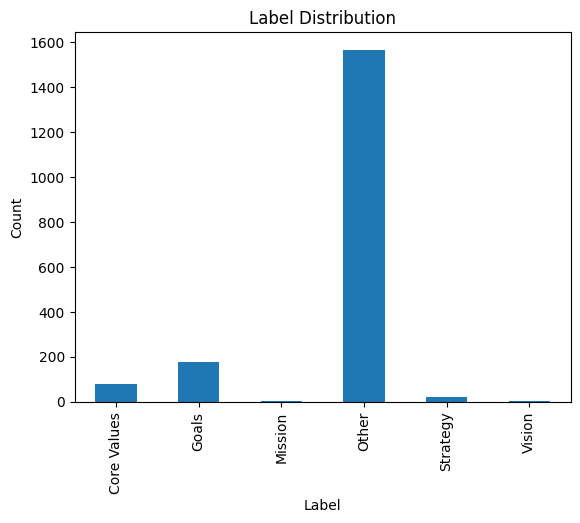

In [9]:

import matplotlib.pyplot as plt

# Top 3 per label
top_per_label = []
for lab in LABELS:
    subset = df[df['label']==lab].sort_values('score', ascending=False).head(3)
    if len(subset):
        top_per_label.append(subset)
if len(top_per_label):
    display(pd.concat(top_per_label)[["page","label","score","text"]])

# Label distribution
lab_counts = df['label'].value_counts().sort_index()
plt.figure()
lab_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


## 10) Save CSV + JSON

### Save the resulting candidates into cvs and json files which we can use to feed in our model.

In [10]:

def save_outputs(rows, out_dir, stem):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    csvp = out / f"{stem}.csv"
    pd.DataFrame(rows).to_csv(csvp, index=False)
    grouped = {lab: [] for lab in LABELS}
    for r in rows:
        if r["label"] in grouped:
            grouped[r["label"]].append({"page": r["page"], "score": r["score"], "text": r["text"]})
    jsonp = out / f"{stem}.json"
    jsonp.write_text(json.dumps(grouped, indent=2, ensure_ascii=False), encoding="utf-8")
    return str(jsonp), str(csvp)

jsonp, csvp = save_outputs(rows, out_dir="/content/outputs", stem=Path(INPUT_PDF).stem)
print("Wrote JSON:", jsonp)
print("Wrote CSV :", csvp)


Wrote JSON: /content/outputs/adidas.json
Wrote CSV : /content/outputs/adidas.csv


In [11]:
# === INPUT & OUTPUT PATHS ===
src_path = "/content/outputs/adidas.csv"          # change this
dst_all = "cleaned_full.csv"
dst_no_other = "cleaned_no_other.csv"
dst_jsonl = "cleaned.jsonl"

# === LOAD DATA ===
df = pd.read_csv(src_path)

# --- Ensure Expected Columns ---
expected_cols = {"pdf","page","label","score","text"}
missing = expected_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV missing required columns: {missing}")

In [12]:
# === CLEANING HELPERS ===

def normalize_text(t: str) -> str:
    """Fix unicode, whitespace, URLs, hyphen-breaks, spacing."""
    if not isinstance(t, str):
        t = "" if pd.isna(t) else str(t)
    t = unicodedata.normalize("NFKC", t)
    t = re.sub(r"https?://\S+|www\.\S+", " ", t)               # remove URLs
    t = re.sub(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", " ", t)          # remove emails
    t = re.sub(r"(\w)-\n(\w)", r"\1\2", t)                     # fix word-breaks
    t = re.sub(r"[ \t]*\n[ \t]*", "\n", t)                     # clean newlines
    t = re.sub(r"\n{3,}", "\n\n", t)                           # collapse blank lines
    t = re.sub(r"[ \t]{2,}", " ", t)                           # collapse spaces
    return t.strip()

In [13]:
# Common boilerplate / disclaimers to remove
BOILERPLATE = [
    r"\bforward[- ]looking statements\b",
    r"\bsafe harbor\b",
    r"\btable of contents\b",
    r"\bcontents?\b$",
    r"\bdisclaimer(s)?\b",
    r"\bnon[- ]IFRS\b",
    r"\bBasis of preparation\b"
]
BOILER_RE = [re.compile(p, re.I|re.M) for p in BOILERPLATE]

def remove_boilerplate(t: str) -> str:
    for r in BOILER_RE:
        t = r.sub(" ", t)
    t = re.sub(r"[ \t]{2,}", " ", t)
    return t.strip()

def is_meaningful(t: str) -> bool:
    """Remove garbage blocks (too short / too few letters)."""
    if len(t) < 50:
        return False
    letters = sum(ch.isalpha() for ch in t)
    if letters / max(1, len(t)) < 0.3:
        return False
    return True

def clean_leading_symbols(t: str) -> str:
    # remove non-alphanumeric “decorators” at start of lines
    return re.sub(r"(^|\n)[^A-Za-z0-9]{1,4}\s*", r"\1", t).strip()

df["text"] = df["text"].map(clean_leading_symbols)

In [14]:
# === APPLY CLEANING ===
df["text"] = df["text"].fillna("").map(normalize_text).map(remove_boilerplate)
df = df[df["text"].map(is_meaningful)].copy()

# Normalize label text
df["label"] = df["label"].astype(str).str.strip()

# === DE-DUPLICATE ===
def signature(t: str) -> str:
    return re.sub(r"\W+", "", t.lower())[:300]

df["_sig"] = df["text"].map(signature)
df = df.drop_duplicates(subset=["label","_sig"]).drop(columns=["_sig"])

# === OPTIONAL LENGTH CAP FOR MODEL USAGE ===
MAX_CHARS = 3500
df["text"] = df["text"].apply(lambda x: x[:MAX_CHARS] + " …" if len(x) > MAX_CHARS else x)

# === SORT FOR READABILITY ===
sort_order = ["Mission","Vision","Core Values","Strategy","Goals","Other"]
df["label"] = pd.Categorical(df["label"], categories=sort_order, ordered=True)
df = df.sort_values(["label","page","score"], ascending=[True, True, False])

# === SAVE OUTPUTS ===
df.to_csv(dst_all, index=False)
df[df["label"] != "Other"].to_csv(dst_no_other, index=False)

with open(dst_jsonl, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        f.write(json.dumps({
            "pdf": row.pdf,
            "page": int(row.page),
            "label": row.label,
            "text": row.text
        }, ensure_ascii=False) + "\n")

print("✅ Cleaning complete!")
print("Full cleaned CSV:", dst_all)
print("Without Other:", dst_no_other)
print("JSONL:", dst_jsonl)
df.head()

✅ Cleaning complete!
Full cleaned CSV: cleaned_full.csv
Without Other: cleaned_no_other.csv
JSONL: cleaned.jsonl


,pdf,page,label,score,text
290,adidas.pdf,406,Mission,0.885714,purpose of funding the pension obligations of ...
775,adidas.pdf,469,Mission,0.564286,purpose of expressing an assurance opinion on ...
511,adidas.pdf,58,Vision,0.735714,our ambition to continuously push industry-wid...
496,adidas.pdf,244,Vision,0.742857,Our ambition is to identify and monitor pay ga...
1814,adidas.pdf,277,Vision,0.000000,Our ambition is to identify and monitor gender...
